In [166]:
from google.colab import drive
drive.mount("gdrive")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

np.random.seed(123)

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


## Data

The data consists of multiple properties for both red and white wines. The goal of this project is to develop a logistic regression model capable of deciding what is the type of a specific wine given its properties (1 for red wine and 0 for white wine). All the functions needed will be written from scratch.

In [167]:
white = pd.read_csv("gdrive/My Drive/Wine Quality/winequality-white.csv", delimiter=";")
red = pd.read_csv("gdrive/My Drive/Wine Quality/winequality-red.csv", delimiter=";")

In [168]:
white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Data is imbalanced.

*   4898 samples of white wine
*   1599 samples of red wine

Total is 6497 samples and the ratio of white to red wine is 3.1



In [169]:
white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [170]:
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [171]:
# Addin wine type and merging

red["type"] = 1
white["type"] = 0
data = red.append(white, ignore_index=True)

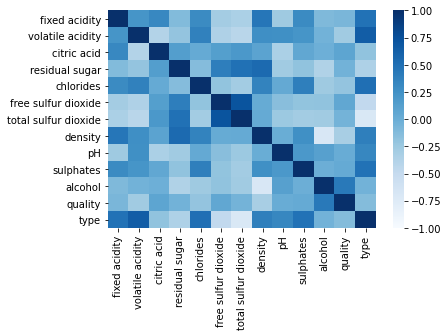

In [172]:
# Correlation Matrix

corr = data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="Blues",
            vmin=-1, vmax=1)

## Logistic Regression Theory

The sigmoid function will be used as the activation function
$$
\sigma(x) = \dfrac{1}{1 + e^{-x}}
$$

In [173]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

Weights and biases will be initialized randomly, with values between -1.0 and +1.0

In [174]:
def initialize_w_b(dim):
  w = np.random.uniform(-1.0, 1.0, dim)
  b = np.random.uniform(-1.0, 1.0, 1)[0]
  return w, b

Forward propagation multiplies the data and the weights and add bias. Note that the dimensions must match.
$$
Z = X.w + b
$$
Here, the data `X` is a matrix where each row represents one sample of wine and each column holds a differente property. If we have `m` samples of wine with `n` properties, `X` is a `m x n` matrix and `w` will be of size `m`.

In [175]:
def forward(w, b, X):
  return sigmoid(np.matmul(X, w) + b)

For the loss function we will use the Binary Cross Entropy, which can be derived assuming that

$$
P(y = 1| X; w, b) = Z = \sigma(X\cdot W + b) \\
P(y = 0 | X; w, b) = 1 - Z \ \ .
$$
This gives
$$
J(w, b) = -\dfrac{1}{m}\sum_{i = 1}^{m}\left[ y_i\log(Z_i) + (1-y_i)\log(1 - Z_i) \right]\ \ ,
$$
where J(w,b) is the loss function average for all samples, yi is the true value for the prediction and Zi is the prediction for the sample i.

The network "learns" when we minimize the loss function, making our predictions closer to the real values. For that we will use a simple form of gradient descent.

In [176]:
def loss(y, Z):
  return -np.mean(y*np.log(Z) + (1 - y)*np.log(1 - Z))

## Gradient Descent

The weights and biases will be updated as follows

$$
w_{i+1} = w_i - \eta dw \\
b_{i+1} = b_i - \eta db\ \ ,
$$
where
$$
dw = \dfrac{\partial J}{\partial w} = \nabla_wJ\ , \ db = \dfrac{\partial J}{\partial b} = \nabla_bJ\ \ .
$$
This gives
$$
dw = \dfrac{1}{m} (Z - y)\cdot X \\
db = \dfrac{1}{m} \sum_{i=0}^{m}(Z_i - y_i) = average(Z - y)\ \,
$$
where dw has the same shape than w and db is a float.

In [177]:
def gradients(X, y, Z):
  dw = (1/X.shape[0])*np.dot(Z - y, X)
  db = np.mean(Z - y)
  return dw, db

## Training

As we have a limited amount of samples (~6k) we will implement k-fold training with k=10. Each training sample will also be divide in batches.

Procedure for each batch:
1.   Forward propagation
2.   Compute gradients
3.   Update weights and bias

And finally, for each fold, calculate the loss.



In [178]:
def divide(size, n):
  """
  Divides an array of length size in ~n sections. Consecutive values in the
  resulting array defines a section.
  """
  for i in range(0, size, size // n):
    if size - i < 2 * size // n:
      yield (i, size)
      break
    yield (i, min(i + size // n, size))


In [179]:
def train(X, Y, k, learning_rate, n_batches):
  """
  X         -> Dataset
  Y         -> Target
  k         -> n_samples in K-Fold
  n_batches -> each training sample generated by k-fold will be divided
               in n_batches
  """
  w, b = initialize_w_b(X.shape[1])
  losses = []
  
  kf = KFold(n_splits=k, shuffle=True)

  for k, (train, test) in enumerate(kf.split(X)):

    t0 = time.perf_counter()

    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]

    for idxa, idxb in divide(X_train.shape[0], n_batches):

      Z = forward(w, b, X_train[idxa:idxb])
      dw, db = gradients(X_train[idxa:idxb], Y_train[idxa:idxb], Z)
      w = w - learning_rate * dw
      b = b - learning_rate * db

    losses.append(loss(Y_test, forward(w, b, X_test)))

    dt = time.perf_counter() - t0
    print(f"k = {k+1}, Loss: {losses[-1]:.5f}, Time: {dt:.4f} s")
    
  return w, b, losses


## Prediction and Metrics

In [180]:
def predict(X, w, b, threshold=0.5):
  Z = forward(w, b, X)
  return (Z >= threshold).astype(int)

In [201]:
def predict_single(wine_sample, w, b, threshold=0.5):
  Z = forward(w, b, wine_sample)
  tp = "Red" if Z >= threshold else "White"
  print(f"Wine type: {tp}")

In [192]:
def accuracy(Z_pred, Y):
  res = np.equal(Z_pred, Y).astype(int)
  return np.sum(res) / res.shape[0]

## Preprocessing and Testing

In [183]:
X = data.iloc[:, :11]            # Dataset
Y = np.ravel(data.iloc[:, 12])   # Target

In [184]:
# Preprocessing (remove mean and divide by std)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [208]:
# Training

w, b, losses = train(X, Y, 8, 0.09, 20)

k = 1, Loss: 0.58240, Time: 0.0014 s
k = 2, Loss: 0.33552, Time: 0.0017 s
k = 3, Loss: 0.24268, Time: 0.0032 s
k = 4, Loss: 0.20808, Time: 0.0011 s
k = 5, Loss: 0.16557, Time: 0.0011 s
k = 6, Loss: 0.14559, Time: 0.0011 s
k = 7, Loss: 0.13952, Time: 0.0011 s
k = 8, Loss: 0.11178, Time: 0.0011 s


In [186]:
# Predictions and accuracy on the entire dataset

pred = predict(X, w, b, threshold=0.5)
acc = accuracy(pred, Y)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 98.32%


In [209]:
# Prediction example (Red = 1, White = 0)

wine_sample = data.iloc[np.random.randint(data.shape[0]), :]
print(wine_sample)
print()
predict_single(np.ravel(wine_sample)[:11], w, b)

fixed acidity             6.900
volatile acidity          0.280
citric acid               0.410
residual sugar            1.700
chlorides                 0.050
free sulfur dioxide      10.000
total sulfur dioxide    136.000
density                   0.993
pH                        3.160
sulphates                 0.710
alcohol                  11.400
quality                   6.000
type                      0.000
Name: 2976, dtype: float64

Wine type: White


In [210]:
confusion_matrix(Y, pred)

array([[4811,   87],
       [  22, 1577]])

In [211]:
precision_score(Y, pred)

0.9477163461538461